In [ ]:
# Import libraries
import glob
import cv2
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import segmentation_models as sm
import numpy as np
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from keras.models import load_model
from keras.metrics import MeanIoU

In [ ]:
# Resizing images
SIZE_X = 128
SIZE_Y = 128

# Define number of classes for segmentation
n_classes= 2

In [ ]:
# Capture training image info as a list
train_images = []

for directory_path in glob.glob("./raw_data/unet_vit/tile/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

# Convert list to array for machine learning processing
train_images = np.array(train_images)

# Capture mask/label info as a list
train_masks = []

for directory_path in glob.glob("./raw_data/unet_vit/tile/masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

# Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [ ]:
test=train_masks[0,:,:]

In [ ]:
# Encode labels

labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

c:\Users\productiontdm\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1], dtype=int64)

In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

# Create a subset of data for quick testing
# Picking 10% for testing and remaining for training

X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

# Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1]


In [ ]:
# Reused parameters in all models
def dice_coef(y_true, y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

n_classes=2
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall()]

# Model 1
BACKBONE1 = 'efficientnetb7'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, loss=dice_coef_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=30,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('efficientnetb7_backbone_30epochs.keras')

85521592/85521592 [==============================] - 55s 1us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                          

In [ ]:
model1.save('efficientnetb7_backbone_30epochs.hdf5')

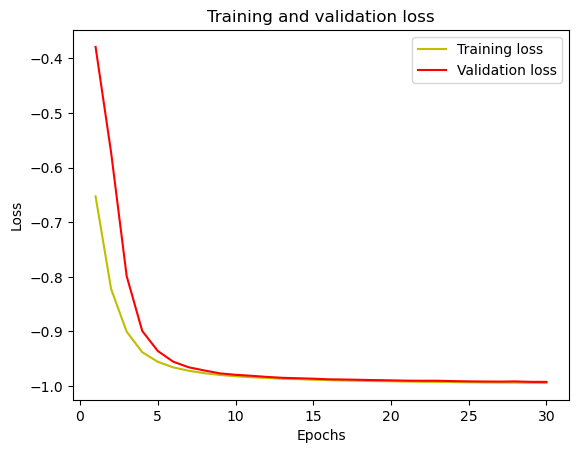

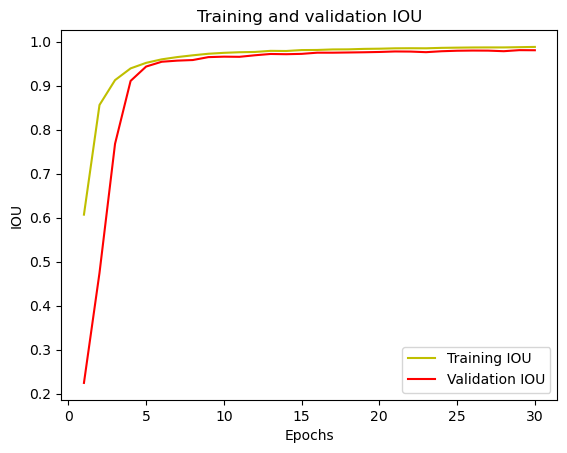

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

[ 1 10 87 20 63 64 44 87 80 59]
3/3 [==============================] - 1s 349ms/step


Text(0.5, 0, 'Prediction')

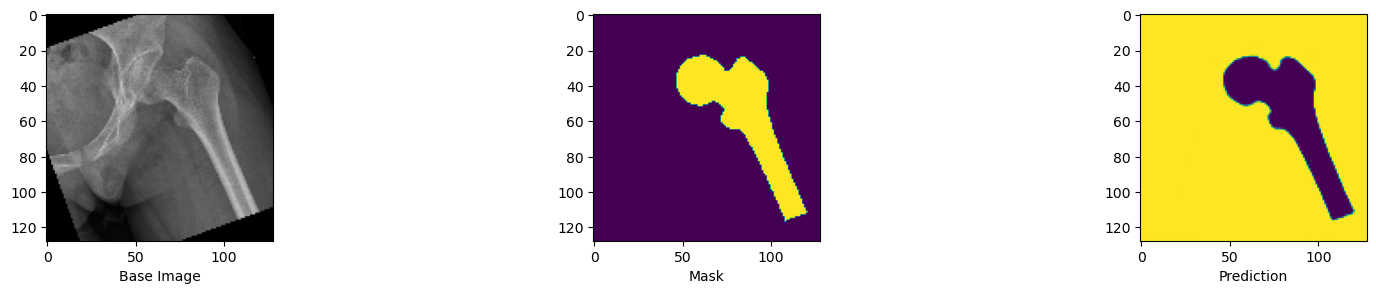

In [ ]:
pred_candidates = np.random.randint(1,X_test.shape[0],10)
print(pred_candidates)
preds = model1.predict(X_test1)

plt.figure(figsize=(20,10))

plt.subplot(3,3,1)

plt.imshow(np.squeeze(X_test[10,:,:,:]))
plt.xlabel("Base Image")

plt.subplot(3,3,i+2)
plt.imshow(np.squeeze(y_test[10,:,:,:]))
plt.xlabel("Mask")

plt.subplot(3,3,i+3)
plt.imshow(np.squeeze(preds[10, :,:,0]))
plt.xlabel("Prediction")

In [ ]:
model1 = load_model('./efficientnetb7_backbone_30epochs.hdf5', compile=False)

In [ ]:
y_pred1=model1.predict('./raw_data/unet_vit/tile/images/105.jpg')

3/3 [==============================] - 1s 337ms/step
Mean IoU = 0.98061293
[[1196761.    2753.]
 [   5142.  237136.]]
IoU for class1 is:  0.9934463
IoU for class2 is:  0.9677796


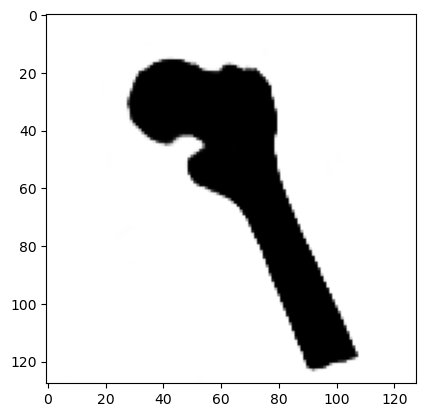

In [ ]:
# IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Calculate I0U for each class
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)

# Verify the prediction on first image
plt.imshow(y_pred1[0, :,:,0], cmap='gray')